<a href="https://colab.research.google.com/github/kumaraguru911/violence-detection-model/blob/main/VDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#step1 Load & Merge Datasets
import pandas as pd
import os
import kagglehub

# Download datasets
jigsaw_path = kagglehub.dataset_download("julian3833/jigsaw-toxic-comment-classification-challenge")
hate_speech_path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

# Load Jigsaw dataset
jigsaw_file = os.path.join(jigsaw_path, "train.csv")
jigsaw_df = pd.read_csv(jigsaw_file)[['comment_text', 'toxic']]
jigsaw_df.rename(columns={'comment_text': 'text', 'toxic': 'label'}, inplace=True)

# Map label 1 = violent, 0 = non-violent
jigsaw_df['label'] = jigsaw_df['label'].apply(lambda x: 1 if x == 1 else 0)

# Load Hate Speech dataset
hate_file = os.path.join(hate_speech_path, "labeled_data.csv")
hate_df = pd.read_csv(hate_file)[['tweet', 'class']]
hate_df.rename(columns={'tweet': 'text', 'class': 'label'}, inplace=True)

# Map labels: 0 (hate speech), 1 (offensive language), 2 (neither)
hate_df['label'] = hate_df['label'].apply(lambda x: 1 if x in [0, 1] else 0)

# Combine both datasets
combined_df = pd.concat([jigsaw_df, hate_df], ignore_index=True)

# Shuffle the dataset
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

print(combined_df['label'].value_counts())
print(combined_df.head())


label
0    148440
1     35914
Name: count, dtype: int64
                                                text  label
0  ":::You grossly misrepresented the Duncan sour...      0
1  ==RFC Against Gamaliel]]\n\nYou might want to ...      0
2  "\nStrong support - I was unaware until this m...      0
3  If it raises you meter another notch... \n\nCh...      0
4  No problem, although this is the second time i...      0


In [ ]:
#Step 2: Text Cleaning & Preprocessing
import re

# Text cleaning function
def clean_text(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove links
    text = re.sub(r'\@[\w]*', '', text)                # Remove @mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)            # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()           # Remove extra whitespaces
    return text

# Apply cleaning
combined_df['clean_text'] = combined_df['text'].apply(clean_text)

# Check cleaned data
print(combined_df[['text', 'clean_text']].head())


                                                text  \
0  ":::You grossly misrepresented the Duncan sour...   
1  ==RFC Against Gamaliel]]\n\nYou might want to ...   
2  "\nStrong support - I was unaware until this m...   
3  If it raises you meter another notch... \n\nCh...   
4  No problem, although this is the second time i...   

                                          clean_text  
0  you grossly misrepresented the duncan source t...  
1  rfc against gamaliel you might want to comment...  
2  strong support i was unaware until this month ...  
3  if it raises you meter another notch check out...  
4  no problem although this is the second time i ...  


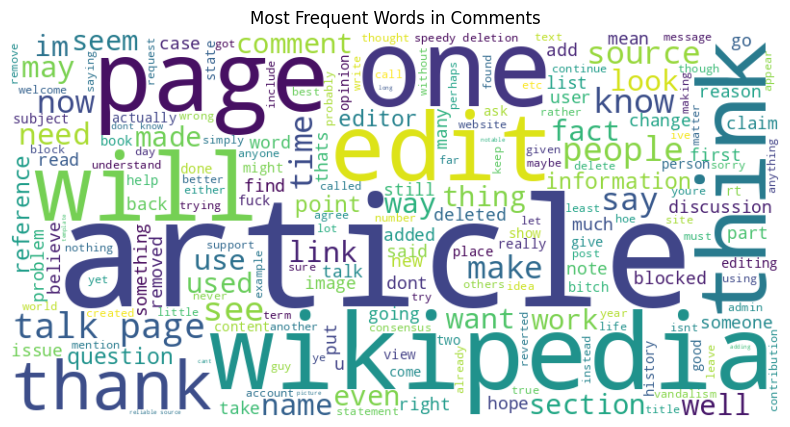

<ipython-input-31-d576865b75d8>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


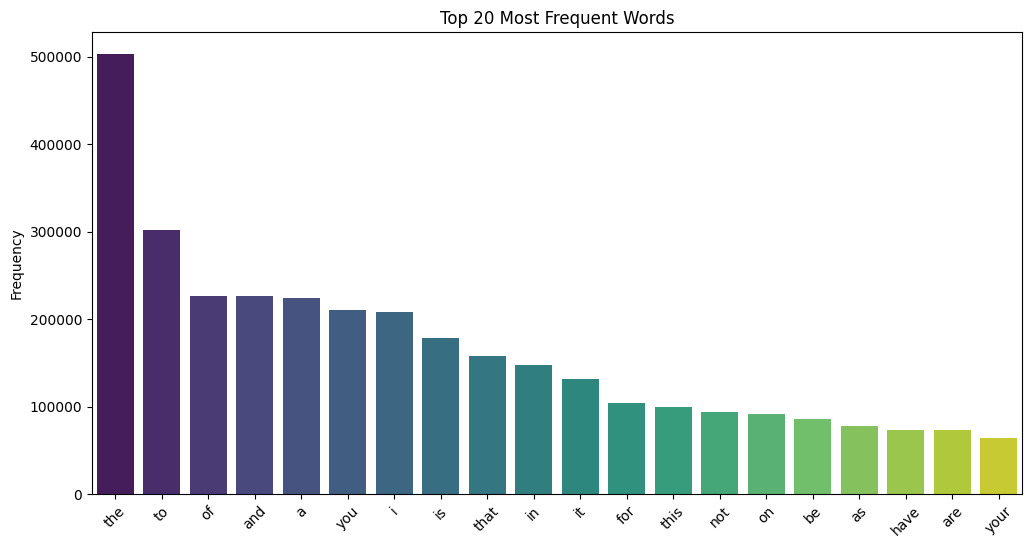

In [ ]:
#Step 3: Tokenizing and Padding Text for LSTM
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned text
all_words = " ".join(combined_df['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Comments")
plt.show()


from collections import Counter
import seaborn as sns

# Tokenize manually (split by space)
words = all_words.split()
word_counts = Counter(words)

# Most common 20 words
common_words = word_counts.most_common(20)

# Plot
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.ylabel("Frequency")
plt.show()



In [ ]:
#Step 4: Tokenizing and Padding the Text Data for LSTM
# Step 4: Tokenize and Pad the Text Data for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences


from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

# Define the maximum number of words to keep based on frequency
max_words = 10000  # You can adjust this based on your dataset size

# Tokenizer: Convert text into sequences of integers
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(combined_df['clean_text'])  # Assuming 'clean_text' contains preprocessed text

# Convert text into sequences
sequences = tokenizer.texts_to_sequences(combined_df['clean_text'])

# Pad the sequences to ensure uniform input size for LSTM
max_sequence_length = 100  # You can adjust the maximum sequence length based on your dataset
X_pad = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training and test sets
X_train_pad, X_test_pad, y_train, y_test = train_test_split(X_pad, combined_df['label'], test_size=0.2, random_state=42)

# Check the shape of the padded data
print(X_train_pad.shape, X_test_pad.shape, y_train.shape, y_test.shape)


(147483, 100) (36871, 100) (147483,) (36871,)


In [ ]:
#Step 5: Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set the embedding dimension
embedding_dim = 100  # You can adjust this based on your dataset

# Define the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))  # Embedding layer
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer with dropout
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the model with a dummy input to initialize weights
model.build((None, max_sequence_length))  # Define the input shape (None for batch size, max_sequence_length for input length)

# Summary of the model
model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

DO NOT TOUCH THE BELOW **CODE**

Epoch 1/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1360s 294ms/step - accuracy: 0.9320 - loss: 0.1865 - val_accuracy: 0.9589 - val_loss: 0.1167
Epoch 2/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1372s 298ms/step - accuracy: 0.9626 - loss: 0.1015 - val_accuracy: 0.9595 - val_loss: 0.1159
Epoch 3/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1378s 299ms/step - accuracy: 0.9667 - loss: 0.0881 - val_accuracy: 0.9573 - val_loss: 0.1195
Epoch 4/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1373s 293ms/step - accuracy: 0.9721 - loss: 0.0724 - val_accuracy: 0.9560 - val_loss: 0.1269
Epoch 5/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1397s 292ms/step - accuracy: 0.9766 - loss: 0.0616 - val_accuracy: 0.9548 - val_loss: 0.1382
Epoch 6/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1342s 291ms/step - accuracy: 0.9811 - loss: 0.0500 - val_accuracy: 0.9519 - val_loss: 0.1579
Epoch 7/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1393s 289ms/step - accuracy: 0.9848 - loss: 0.0415 - val_accuracy: 0.9516 - val_loss: 0.1784
Epoch 8/10
4609/4609 ━━━━━━━━━━━━━━━━━━━━ 1344s 290ms/s

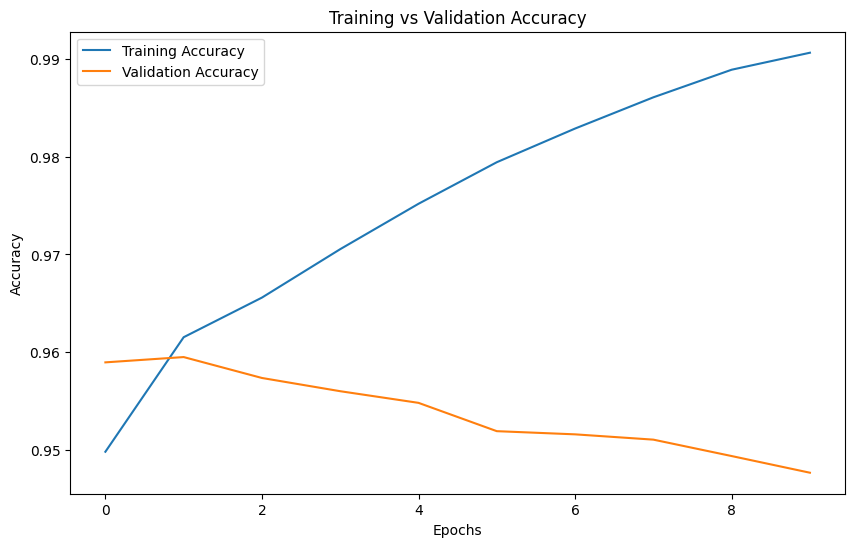

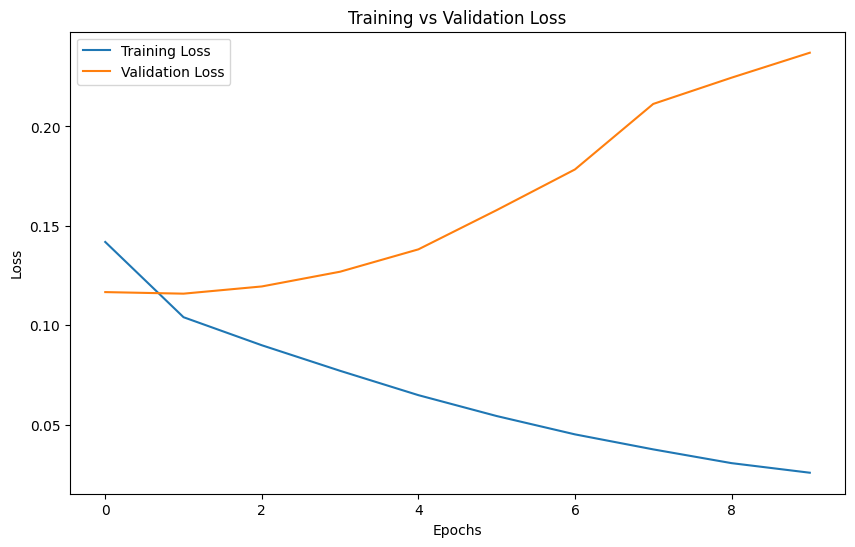

In [32]:
# Step 6: Compile and Train the Model
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=10,  # You can increase the number of epochs as needed
                    batch_size=32,
                    validation_data=(X_test_pad, y_test))

# Check the model training history
print(history.history)

# Visualization of Training and Validation Accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Visualization of Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [33]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Predict on the test data
y_pred = model.predict(X_test_pad)

# Convert predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Display the first few predictions along with actual labels
print("Predictions vs Actual Labels:")
for i in range(10):
    print(f"Prediction: {y_pred_binary[i][0]}, Actual: {y_test.iloc[i]}")


1153/1153 - 49s - 42ms/step - accuracy: 0.9476 - loss: 0.2371
Test Accuracy: 0.9476282000541687
Test Loss: 0.23708999156951904
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step
Predictions vs Actual Labels:
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0


💬 Enter a comment to analyze (type 'stop' to finish): he is a good boy

📝 Comment: he is a good boy
📊 Prediction: Non-Violent (Confidence: 0.01)
💬 Enter a comment to analyze (type 'stop' to finish): we will enjoy this weekend

📝 Comment: we will enjoy this weekend
📊 Prediction: Non-Violent (Confidence: 0.00)
💬 Enter a comment to analyze (type 'stop' to finish): he's a bad guy

📝 Comment: he's a bad guy
📊 Prediction: Non-Violent (Confidence: 0.10)
💬 Enter a comment to analyze (type 'stop' to finish): you are so ugly

📝 Comment: you are so ugly
📊 Prediction: Violent (Confidence: 0.87)
💬 Enter a comment to analyze (type 'stop' to finish): stop

✅ Prediction session ended. Now showing graph(s)...


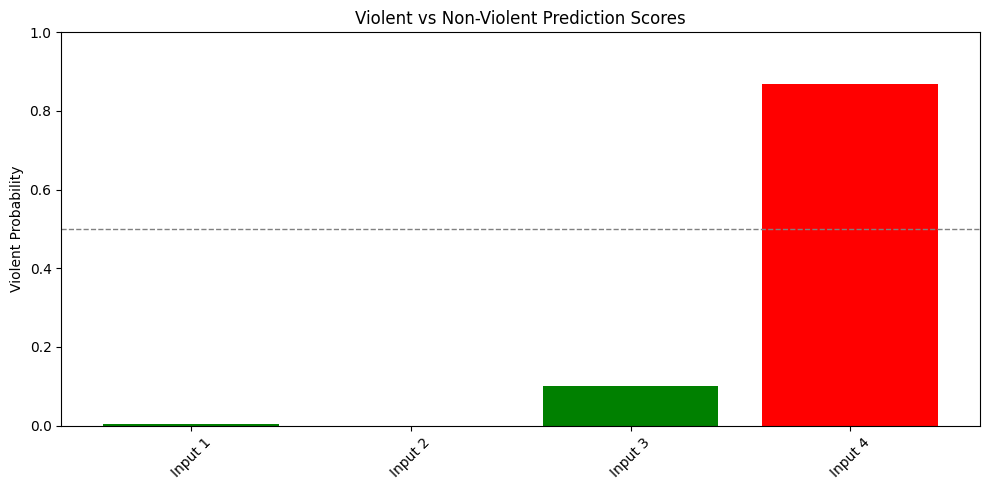

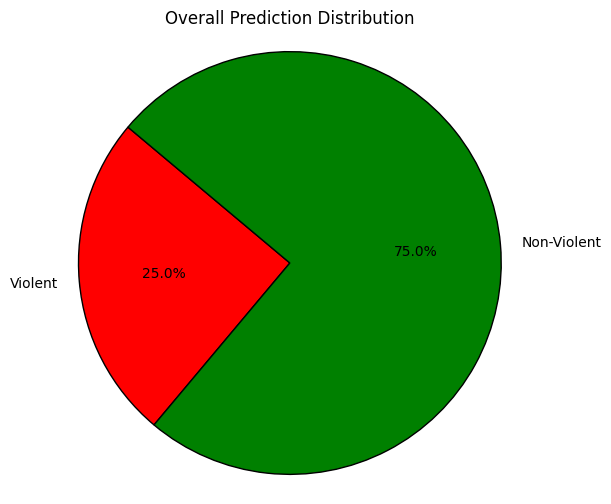

In [37]:
# Step 8: Real-Time Prediction with Visualization
import matplotlib.pyplot as plt
import numpy as np

# Lists to collect predictions for plotting after all inputs
texts_entered = []
predicted_probs = []
predicted_labels = []

def predict_and_store(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_sequence_length)
    pred = model.predict(pad, verbose=0)[0][0]
    label = "Violent" if pred >= 0.5 else "Non-Violent"

    # Show result immediately
    print(f"\n📝 Comment: {text}")
    print(f"📊 Prediction: {label} (Confidence: {pred:.2f})")

    # Store for plotting
    texts_entered.append(text)
    predicted_probs.append(pred)
    predicted_labels.append(label)

# Input loop
while True:
    user_text = input("💬 Enter a comment to analyze (type 'stop' to finish): ")
    if user_text.lower().strip() == "stop":
        print("\n✅ Prediction session ended. Now showing graph(s)...")
        break
    elif user_text.strip() == "":
        print("⚠️ Please enter a non-empty comment.")
        continue
    predict_and_store(user_text)

# Show graph only after loop ends
if texts_entered:
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(texts_entered)), predicted_probs, color=["red" if p >= 0.5 else "green" for p in predicted_probs])
    plt.xticks(range(len(texts_entered)), [f"Input {i+1}" for i in range(len(texts_entered))], rotation=45)
    plt.ylabel("Violent Probability")
    plt.ylim(0, 1)
    plt.title("Violent vs Non-Violent Prediction Scores")
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

    violent_count = sum(p >= 0.5 for p in predicted_probs)
    non_violent_count = len(predicted_probs) - violent_count

    # Labels and sizes
    labels = ['Violent', 'Non-Violent']
    sizes = [violent_count, non_violent_count]
    colors = ['red', 'green']

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=140, wedgeprops={'edgecolor': 'black'})
    plt.title("Overall Prediction Distribution")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is a circle.
    plt.show()
else:
    print("📭 No comments were entered.")
